In [1]:
# ELECTRICAL ASSET INTELLIGENCE PLATFORM
# 05: Prescriptive Engine Demo Notebook (Merged & Hardened)
# SPE AI/ML Boot Camp Final Project

# Standard imports
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
from datetime import datetime
import json
import logging
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA

# Optional heavy imports wrapped in try/except
try:
    import joblib
except Exception:
    joblib = None

try:
    import tensorflow as tf
except Exception:
    tf = None

# Jupyter inline plotting if available
try:
    get_ipython().run_line_magic('matplotlib', 'inline')
except Exception:
    pass

# Visual style
sns.set_theme(style='whitegrid')
sns.set_palette("viridis")
plt.rcParams.update({'figure.max_open_warning': 0})

# Paths
BASE_DIR = Path('..')
DATA_DIR = BASE_DIR / 'data'
MODELS_DIR = BASE_DIR / 'models'
RESULTS_DIR = BASE_DIR / 'results'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logging.info("Notebook initialized.")

INFO: Notebook initialized.


In [2]:
# Utilities: safe file/model loading & helpers
def safe_read_csv(path: Path):
    if not path.exists():
        raise FileNotFoundError(f"Data file not found: {path}")
    return pd.read_csv(path)

def try_load_joblib(path: Path):
    if joblib is None:
        logging.warning("joblib not installed - cannot load .pkl models")
        return None
    try:
        return joblib.load(path)
    except Exception as e:
        logging.warning(f"Could not load joblib model at {path}: {e}")
        return None

def try_load_keras(path: Path):
    if tf is None:
        logging.warning("tensorflow not installed - cannot load .h5 models")
        return None
    try:
        return tf.keras.models.load_model(path)
    except Exception as e:
        logging.warning(f"Could not load Keras model at {path}: {e}")
        return None

def norm_arr(a):
    a = np.array(a, dtype=float)
    if a.size == 0:
        return a
    amin, amax = a.min(), a.max()
    if amax - amin < 1e-8:
        return np.zeros_like(a)
    return (a - amin) / (amax - amin)

In [4]:
# Load pre-trained models (with graceful fallback to None)
import logging
import os
from pathlib import Path
import joblib
import tensorflow as tf
from tensorflow import keras
import warnings

# Suppress specific Keras warnings
warnings.filterwarnings('ignore', category=UserWarning, module='keras')

logging.info("Loading pre-trained models...")

def try_load_joblib(path):
    """Load joblib model with error handling."""
    if not os.path.exists(path):
        return None
    try:
        return joblib.load(path)
    except Exception as e:
        logging.warning(f"Could not load joblib model at {path}: {str(e)}")
        return None

def try_load_keras(path):
    """Load Keras model with comprehensive error handling."""
    if not os.path.exists(path):
        return None
    
    try:
        # Method 1: Load without compilation (most compatible)
        model = tf.keras.models.load_model(path, compile=False)
        
        # Recompile with current Keras syntax
        model.compile(
            optimizer='adam',
            loss='mse',
            metrics=['mae']
        )
        return model
        
    except Exception as e:
        logging.warning(f"Primary Keras loading failed for {path}: {str(e)}")
        
        # Method 2: Try with custom objects mapping
        try:
            custom_objects = {
                'mse': 'mean_squared_error',
                'mae': 'mean_absolute_error',
                'accuracy': 'accuracy'
            }
            model = tf.keras.models.load_model(path, custom_objects=custom_objects, compile=False)
            model.compile(optimizer='adam', loss='mse', metrics=['mae'])
            return model
            
        except Exception as e2:
            logging.warning(f"Secondary Keras loading failed for {path}: {str(e2)}")
            
            # Method 3: Try loading weights only (if model architecture is known)
            try:
                # This would require you to define the model architecture separately
                # For now, we'll just return None
                logging.warning(f"All Keras loading methods failed for {path}")
                return None
                
            except Exception as e3:
                logging.warning(f"Final Keras loading attempt failed for {path}: {str(e3)}")
                return None

def load_model(model_type, asset_type):
    """Load a pre-trained model if present; return None otherwise."""
    if model_type == 'random_forest':
        p = MODELS_DIR / f'best_random_forest_{asset_type}.pkl'
        return try_load_joblib(p)
    elif model_type == 'lstm_autoencoder':
        p = MODELS_DIR / f'lstm_autoencoder_{asset_type}.h5'
        return try_load_keras(p)
    elif model_type == 'isolation_forest':
        p = MODELS_DIR / f'isolation_forest_{asset_type}.pkl'
        return try_load_joblib(p)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

# Load all models with comprehensive error handling
models = {}
successful_loads = 0
total_models = 0

for asset_type in ['transformer', 'motor', 'capacitor', 'ups']:
    models[asset_type] = {}
    
    for model_name, model_type in [
        ('classifier', 'random_forest'),
        ('lstm', 'lstm_autoencoder'), 
        ('isolation_forest', 'isolation_forest')
    ]:
        total_models += 1
        loaded_model = load_model(model_type, asset_type)
        models[asset_type][model_name] = loaded_model
        
        if loaded_model is not None:
            successful_loads += 1
            logging.info(f"✓ Successfully loaded {model_type} for {asset_type}")
        else:
            logging.info(f"✗ Could not load {model_type} for {asset_type} - will use fallback")

logging.info(f"Model loading completed: {successful_loads}/{total_models} models loaded successfully.")
logging.info("Missing models will be handled by fallbacks during runtime.")


INFO: Loading pre-trained models...
INFO: ✓ Successfully loaded random_forest for transformer
INFO: ✓ Successfully loaded lstm_autoencoder for transformer
INFO: ✓ Successfully loaded isolation_forest for transformer
INFO: ✓ Successfully loaded random_forest for motor
INFO: ✓ Successfully loaded lstm_autoencoder for motor
INFO: ✓ Successfully loaded isolation_forest for motor
INFO: ✓ Successfully loaded random_forest for capacitor
INFO: ✓ Successfully loaded lstm_autoencoder for capacitor
INFO: ✓ Successfully loaded isolation_forest for capacitor
INFO: ✓ Successfully loaded random_forest for ups
INFO: ✓ Successfully loaded lstm_autoencoder for ups
INFO: ✓ Successfully loaded isolation_forest for ups
INFO: Model loading completed: 12/12 models loaded successfully.
INFO: Missing models will be handled by fallbacks during runtime.


In [7]:
# Load and preprocess data (keeps original rolling features / categorical conversions)
logging.info("Loading and preprocessing data...")

def load_and_preprocess_data(asset_type):
    p = DATA_DIR / f'{asset_type}_data.csv'
    df = safe_read_csv(p)

    # Date handling (if present)
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df = df.sort_values('date').reset_index(drop=True)
        df['day_of_week'] = df['date'].dt.dayofweek.fillna(0).astype(int)
        df['month'] = df['date'].dt.month.fillna(1).astype(int)
        df['day_of_year'] = df['date'].dt.dayofyear.fillna(1).astype(int)
        df_with_date = df.copy()
        df = df.drop(columns=['date'])
    else:
        df_with_date = df.copy()

    # Rolling features and rates (guard columns exist)
    if asset_type == 'transformer':
        if 'oil_temp_c' in df.columns:
            df['oil_temp_7d_avg'] = df['oil_temp_c'].rolling(window=7, min_periods=1).mean()
            df['oil_temp_rate'] = df['oil_temp_c'].diff().fillna(0)
        if 'winding_temp_c' in df.columns:
            df['winding_temp_7d_avg'] = df['winding_temp_c'].rolling(window=7, min_periods=1).mean()
            df['winding_temp_rate'] = df['winding_temp_c'].diff().fillna(0)
        if 'oil_temp_c' in df.columns and 'winding_temp_c' in df.columns:
            df['temp_diff'] = df['winding_temp_c'] - df['oil_temp_c']
            df['temp_diff_7d_avg'] = df['temp_diff'].rolling(window=7, min_periods=1).mean()
    elif asset_type == 'motor':
        if 'vibration_mm_s' in df.columns:
            df['vibration_7d_avg'] = df['vibration_mm_s'].rolling(window=7, min_periods=1).mean()
            df['vibration_rate'] = df['vibration_mm_s'].diff().fillna(0)
        if 'temperature_c' in df.columns:
            df['temp_7d_avg'] = df['temperature_c'].rolling(window=7, min_periods=1).mean()
            df['temp_rate'] = df['temperature_c'].diff().fillna(0)
    elif asset_type == 'capacitor':
        if 'temperature_c' in df.columns:
            df['temp_7d_avg'] = df['temperature_c'].rolling(window=7, min_periods=1).mean()
            df['temp_rate'] = df['temperature_c'].diff().fillna(0)
        if 'harmonic_distortion_percent' in df.columns:
            df['harmonic_7d_avg'] = df['harmonic_distortion_percent'].rolling(window=7, min_periods=1).mean()
            df['harmonic_rate'] = df['harmonic_distortion_percent'].diff().fillna(0)
    elif asset_type == 'ups':
        if 'voltage_per_cell_v' in df.columns:
            df['voltage_7d_avg'] = df['voltage_per_cell_v'].rolling(window=7, min_periods=1).mean()
            df['voltage_rate'] = df['voltage_per_cell_v'].diff().fillna(0)
        if 'temperature_c' in df.columns:
            df['temp_7d_avg'] = df['temperature_c'].rolling(window=7, min_periods=1).mean()
            df['temp_rate'] = df['temperature_c'].diff().fillna(0)

    # Categorical conversions (safe)
    if asset_type == 'transformer' and 'oil_quality' in df.columns:
        df = pd.get_dummies(df, columns=['oil_quality'], prefix='oil_quality')
    if asset_type == 'motor' and 'bearing_condition' in df.columns:
        df = pd.get_dummies(df, columns=['bearing_condition'], prefix='bearing')
    if asset_type == 'capacitor' and 'fuse_status' in df.columns:
        df = pd.get_dummies(df, columns=['fuse_status'], prefix='fuse')
    if asset_type == 'ups' and 'operating_mode' in df.columns:
        df = pd.get_dummies(df, columns=['operating_mode'], prefix='mode')

    # Health mapping
    if 'health_status' not in df.columns:
        df['health_status'] = 'Healthy'
    health_mapping = {'Healthy': 0, 'Warning': 1, 'Critical': 2}
    df['health_status_num'] = df['health_status'].map(health_mapping).fillna(0).astype(int)
    if 'failure_mode' not in df.columns:
        df['failure_mode'] = np.nan

    drop_cols = [c for c in ['health_status', 'health_status_num', 'failure_mode'] if c in df.columns]
    X = df.drop(columns=drop_cols)
    y = df['health_status_num']

    return X.reset_index(drop=True), y.reset_index(drop=True), df.reset_index(drop=True), health_mapping, df_with_date.reset_index(drop=True)

# Load datasets
datasets = {}
for asset in ['transformer', 'motor', 'capacitor', 'ups']:
    try:
        X, y, df, mapping, df_with_date = load_and_preprocess_data(asset)
        datasets[asset] = {'X': X, 'y': y, 'df': df, 'mapping': mapping, 'df_with_date': df_with_date}
        logging.info(f"Loaded {asset}: {len(X)} rows.")
    except Exception as e:
        logging.error(f"Failed to load {asset} dataset: {e}")
        datasets[asset] = {'X': pd.DataFrame(), 'y': pd.Series(dtype=int), 'df': pd.DataFrame(), 'mapping': {}, 'df_with_date': pd.DataFrame()}


INFO: Loading and preprocessing data...
INFO: Loaded transformer: 1000 rows.
INFO: Loaded motor: 1000 rows.
INFO: Loaded capacitor: 1000 rows.
INFO: Loaded ups: 1000 rows.


INFO: Estimating failure probabilities and time-to-failure...
INFO: Estimating failure risk for transformer (1000 rows).
INFO: [transformer] Aligned features: 18 features
INFO: [transformer] Truncated features from 18 to 6 for LSTM
INFO: [transformer] Adjusted features for IsolationForest: 18 -> 6


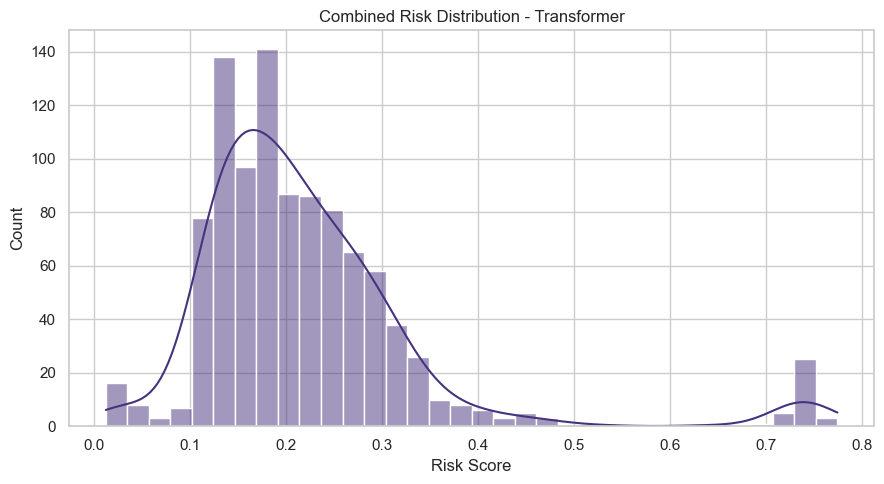

INFO: Estimating failure risk for motor (1000 rows).
INFO: [motor] Aligned features: 16 features
INFO: [motor] Truncated features from 16 to 6 for LSTM
INFO: [motor] Adjusted features for IsolationForest: 16 -> 6


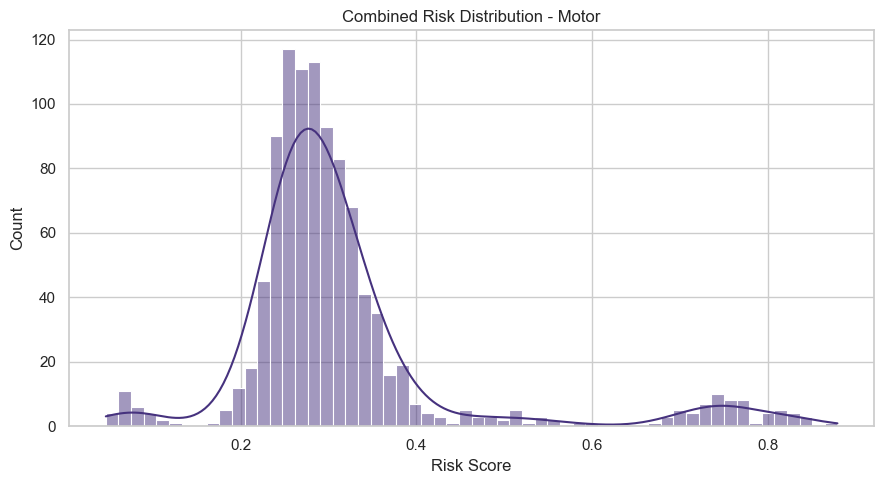

INFO: Estimating failure risk for capacitor (1000 rows).
INFO: [capacitor] Aligned features: 15 features
INFO: [capacitor] Truncated features from 15 to 6 for LSTM
INFO: [capacitor] Adjusted features for IsolationForest: 15 -> 6


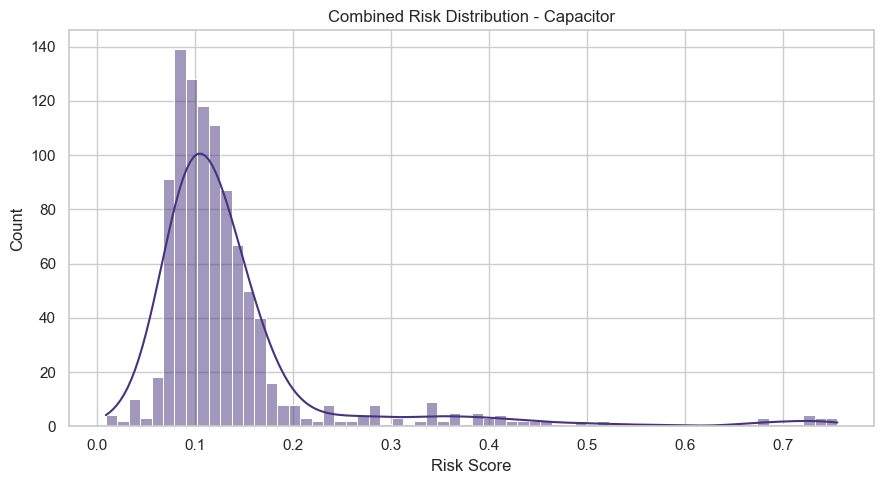

INFO: Estimating failure risk for ups (1000 rows).
INFO: [ups] Aligned features: 15 features
INFO: [ups] Truncated features from 15 to 5 for LSTM
INFO: [ups] Adjusted features for IsolationForest: 15 -> 5


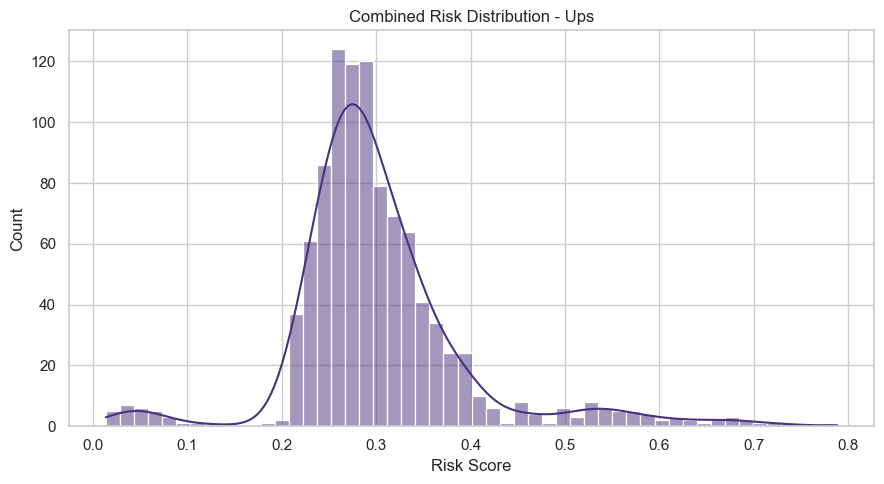

In [9]:
# 1. Failure Probability and Time-to-Failure Estimation
logging.info("Estimating failure probabilities and time-to-failure...")

def estimate_failure_risk(classifier, X, y, asset_type, window_size=30):
    """Estimate failure risk using classifier + LSTM (or PCA fallback) + IsolationForest (or proxy)."""
    n = len(X)
    if n == 0:
        return {'failure_probs': np.array([]),'time_to_failure': np.array([]),'lstm_anomaly_score': np.array([]),'iso_anomaly_score': np.array([]),'combined_risk': np.array([])}

    # SOLUTION: Feature alignment for classifier
    X_processed = X.copy()
    
    # Get expected features from model if available
    if classifier is not None and hasattr(classifier, 'feature_names_in_'):
        expected_features = classifier.feature_names_in_
        current_features = X.columns.tolist()
        
        # Align features: add missing ones as zeros, reorder to match training
        for feat in expected_features:
            if feat not in current_features:
                X_processed[feat] = 0
        
        # Reorder columns to match training order
        X_processed = X_processed[expected_features]
        logging.info(f"[{asset_type}] Aligned features: {len(expected_features)} features")

    # Classifier probabilities (fallback to Dummy)
    if classifier is None:
        logging.info(f"[{asset_type}] No classifier found — using Dummy fallback.")
        dummy = DummyClassifier(strategy='most_frequent')
        try:
            dummy.fit(np.zeros((n, 1)), y)
            class_probs = dummy.predict_proba(np.zeros((n, 1)))
        except Exception:
            class_probs = np.repeat(np.array([[0.7,0.2,0.1]]), n, axis=0)
    else:
        try:
            class_probs = classifier.predict_proba(X_processed)
        except Exception as e:
            logging.warning(f"[{asset_type}] classifier.predict_proba failed: {e}. Using fallback probs.")
            try:
                preds = classifier.predict(X_processed)
                class_probs = np.zeros((n, 3))
                for i,p in enumerate(preds):
                    class_probs[i, int(p)] = 0.9
                    class_probs[i] += 0.05
            except Exception:
                class_probs = np.repeat(np.array([[0.7,0.2,0.1]]), n, axis=0)

    # Weighted failure probability (Warning + Critical)
    failure_probs = 0.3 * class_probs[:,1] + 0.7 * class_probs[:,2]

    # Time to failure heuristic (original logic preserved)
    time_to_failure = np.zeros(n)
    for i in range(n):
        st = int(y.iloc[i]) if i < len(y) else 0
        p = float(failure_probs[i])
        if st == 2:
            time_to_failure[i] = max(1.0, 3.0 - 2.0 * p)
        elif st == 1:
            time_to_failure[i] = max(3.0, 7.0 - 4.0 * p)
        else:
            time_to_failure[i] = max(10.0, 15.0 - 5.0 * p)

    # SOLUTION: Feature alignment for anomaly detectors
    # Use the same processed features for consistency
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_processed.fillna(0).values)

    # LSTM reconstruction error - try model; fallback to PCA-based reconstruction error
    lstm_model = models[asset_type]['lstm'] if asset_type in models else None
    lstm_anomaly_score = np.zeros(len(X_scaled))
    
    try:
        if lstm_model is not None:
            # SOLUTION: Check LSTM input dimensions and reshape accordingly
            expected_features = lstm_model.input_shape[-1] if hasattr(lstm_model, 'input_shape') else X_scaled.shape[1]
            
            # Adjust features to match LSTM expected input
            if X_scaled.shape[1] != expected_features:
                if X_scaled.shape[1] > expected_features:
                    # Truncate features
                    X_scaled_lstm = X_scaled[:, :expected_features]
                    logging.info(f"[{asset_type}] Truncated features from {X_scaled.shape[1]} to {expected_features} for LSTM")
                else:
                    # Pad with zeros
                    padding = np.zeros((X_scaled.shape[0], expected_features - X_scaled.shape[1]))
                    X_scaled_lstm = np.hstack([X_scaled, padding])
                    logging.info(f"[{asset_type}] Padded features from {X_scaled.shape[1]} to {expected_features} for LSTM")
            else:
                X_scaled_lstm = X_scaled
            
            n_samples = X_scaled_lstm.shape[0] - window_size + 1
            if n_samples > 0:
                X_reshaped = np.array([X_scaled_lstm[i:i+window_size] for i in range(n_samples)])
                X_pred = lstm_model.predict(X_reshaped, verbose=0)
                mse = np.mean(np.power(X_reshaped - X_pred, 2), axis=(1,2))
                for i in range(len(mse)):
                    lstm_anomaly_score[i+window_size-1] = mse[i]
            else:
                raise ValueError("Insufficient samples for LSTM windowing")
        else:
            raise ValueError("No LSTM model")
    except Exception as e:
        logging.info(f"[{asset_type}] LSTM unavailable or failed: {e} — using PCA fallback for anomaly score.")
        try:
            n_features = X_scaled.shape[1]
            n_components = min(max(1, n_features // 2), 8)
            pca = PCA(n_components=n_components, random_state=0)
            X_proj = pca.fit_transform(X_scaled)
            X_rec = pca.inverse_transform(X_proj)
            lstm_anomaly_score = np.mean((X_scaled - X_rec) ** 2, axis=1)
        except Exception as e2:
            logging.error(f"PCA fallback failed: {e2}. Using z-score anomaly proxy.")
            lstm_anomaly_score = np.mean(np.abs((X_scaled - np.mean(X_scaled, axis=0)) / (np.std(X_scaled, axis=0) + 1e-8)), axis=1)

    # SOLUTION: Feature alignment for Isolation Forest
    iso_model = models[asset_type]['isolation_forest'] if asset_type in models else None
    try:
        if iso_model is not None:
            # Check if isolation forest expects different number of features
            if hasattr(iso_model, 'n_features_in_'):
                expected_features_iso = iso_model.n_features_in_
                if X_scaled.shape[1] != expected_features_iso:
                    if X_scaled.shape[1] > expected_features_iso:
                        X_scaled_iso = X_scaled[:, :expected_features_iso]
                    else:
                        padding = np.zeros((X_scaled.shape[0], expected_features_iso - X_scaled.shape[1]))
                        X_scaled_iso = np.hstack([X_scaled, padding])
                    logging.info(f"[{asset_type}] Adjusted features for IsolationForest: {X_scaled.shape[1]} -> {expected_features_iso}")
                else:
                    X_scaled_iso = X_scaled
            else:
                X_scaled_iso = X_scaled
                
            iso_scores = -iso_model.decision_function(X_scaled_iso)
        else:
            raise ValueError("No isolation forest model")
    except Exception as e:
        logging.info(f"[{asset_type}] IsolationForest unavailable — using statistical anomaly proxy. Error: {e}")
        iso_scores = np.mean(np.abs(X_scaled - np.median(X_scaled, axis=0)), axis=1)

    # Combine scores (normalized)
    combined_risk = 0.4 * norm_arr(failure_probs) + 0.35 * norm_arr(lstm_anomaly_score) + 0.25 * norm_arr(iso_scores)
    combined_risk = np.clip(combined_risk, 0.0, 1.0)

    return {
        'failure_probs': failure_probs,
        'time_to_failure': time_to_failure,
        'lstm_anomaly_score': lstm_anomaly_score,
        'iso_anomaly_score': iso_scores,
        'combined_risk': combined_risk
    }

# Run risk estimation for each asset type and plot/save distributions
failure_risk = {}
for asset_type in ['transformer','motor','capacitor','ups']:
    X = datasets[asset_type]['X']
    y = datasets[asset_type]['y']
    logging.info(f"Estimating failure risk for {asset_type} ({len(X)} rows).")
    risk = estimate_failure_risk(models[asset_type]['classifier'], X, y, asset_type)
    failure_risk[asset_type] = risk

    if risk['combined_risk'].size > 0:
        plt.figure(figsize=(9,5))
        sns.histplot(risk['combined_risk'], kde=True)
        plt.title(f'Combined Risk Distribution - {asset_type.capitalize()}')
        plt.xlabel('Risk Score'); plt.ylabel('Count')
        plt.tight_layout()
        plt.show()
        plt.savefig(RESULTS_DIR / f'risk_distribution_{asset_type}.png', dpi=200, bbox_inches='tight')
        plt.close()


In [30]:
# 2. Enhanced Failure Mode Identification
logging.info("Identifying failure modes...")

def convert_to_serializable(obj):
    """Convert numpy/pandas types to JSON serializable Python types"""
    if hasattr(obj, 'item'):  # numpy scalar
        return obj.item()
    elif hasattr(obj, 'tolist'):  # numpy array
        return obj.tolist()
    elif pd.isna(obj):  # pandas NaN
        return None
    elif isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, np.bool_):
        return bool(obj)
    else:
        return obj

def identify_failure_modes(asset_type, X, df, risk_data, top_n=5):
    """
    Enhanced failure mode identification with better error handling and feature analysis
    """
    modes = {}
    
    # Input validation
    if X.empty or risk_data['combined_risk'].size == 0:
        logging.warning(f"Empty data for {asset_type}, skipping failure mode identification")
        return modes
    
    # Ensure risk data matches feature data length
    risk_scores = risk_data['combined_risk'][:len(X)]
    if len(risk_scores) == 0:
        logging.warning(f"No risk scores available for {asset_type}")
        return modes
    
    # Select top risk indices safely
    sorted_idx = np.argsort(risk_scores)
    actual_top_n = min(top_n, len(sorted_idx))
    top_indices = sorted_idx[-actual_top_n:][::-1]
    
    # Feature importance calculation with enhanced fallback logic
    clf = models.get(asset_type, {}).get('classifier')
    
    if clf is not None and hasattr(clf, 'feature_importances_'):
        # Use model feature importances
        importances = np.array(clf.feature_importances_)
        feat_names = X.columns.tolist()
        logging.info(f"Using model feature importances for {asset_type}")
    else:
        # Fallback to correlation-based importance
        feat_names = X.columns.tolist()
        importances = np.zeros(len(feat_names))
        cr = pd.Series(risk_scores)
        
        logging.info(f"Using correlation-based feature importance for {asset_type}")
        for i, col in enumerate(feat_names):
            try:
                col_data = pd.Series(X[col][:len(cr)])
                # Handle non-numeric columns
                if pd.api.types.is_numeric_dtype(col_data):
                    correlation = abs(col_data.corr(cr))
                    importances[i] = correlation if not pd.isna(correlation) else 0.0
                else:
                    importances[i] = 0.0
            except Exception as e:
                logging.warning(f"Error calculating correlation for {col}: {e}")
                importances[i] = 0.0
    
    # Sort features by importance
    order = np.argsort(importances)[::-1]
    
    # Enhanced failure mode detection
    for rank, idx in enumerate(top_indices):
        if idx >= len(X):
            continue
            
        # Get top contributing features
        top_feat_indices = order[:5]
        top_feats = [feat_names[i] for i in top_feat_indices]
        top_vals = []
        
        # Safely extract feature values and convert to serializable types
        for feat in top_feats:
            try:
                if feat in X.columns:
                    val = X.iloc[idx, X.columns.get_loc(feat)]
                    top_vals.append(convert_to_serializable(val))
                else:
                    top_vals.append(None)
            except Exception as e:
                logging.warning(f"Error extracting value for feature {feat}: {e}")
                top_vals.append(None)
        
        # Enhanced failure mode classification
        failure_mode, confidence = classify_failure_mode(asset_type, top_feats, top_vals, importances[top_feat_indices])
        
        # Additional analysis
        risk_score = convert_to_serializable(risk_scores[idx])
        
        modes[int(idx)] = {
            'failure_mode': failure_mode,
            'confidence': round(confidence, 3),
            'risk_score': risk_score,
            'risk_rank': rank + 1,
            'top_features': [
                {
                    'name': feat,
                    'value': val,
                    'importance': convert_to_serializable(importances[top_feat_indices[i]])
                }
                for i, (feat, val) in enumerate(zip(top_feats, top_vals))
            ],
            'asset_id': convert_to_serializable(df.iloc[idx].get('asset_id', f"{asset_type}_{idx}")) if idx < len(df) else f"{asset_type}_{idx}"
        }
    
    return modes

def classify_failure_mode(asset_type, top_feats, top_vals, importances):
    """
    Enhanced failure mode classification with confidence scoring
    """
    tf_lower = [str(t).lower() for t in top_feats if t is not None]
    failure_mode = "Unknown"
    confidence = 0.5
    
    # Enhanced heuristics with confidence weighting
    if asset_type == 'transformer':
        insulation_keywords = ['insulation', 'partial_discharge', 'pd', 'dielectric']
        thermal_keywords = ['temp', 'temperature', 'thermal', 'winding', 'hotspot']
        oil_keywords = ['oil', 'moisture', 'acidity', 'dga']
        
        if any(keyword in feat for feat in tf_lower for keyword in insulation_keywords):
            failure_mode = "Insulation Degradation"
            confidence = 0.85 if sum(importances[:2]) > 0.3 else 0.7
        elif any(keyword in feat for feat in tf_lower for keyword in thermal_keywords):
            failure_mode = "Overheating"
            confidence = 0.8 if any('temp' in feat for feat in tf_lower) else 0.65
        elif any(keyword in feat for feat in tf_lower for keyword in oil_keywords):
            failure_mode = "Oil Degradation"
            confidence = 0.75
        elif any('tap' in feat or 'oltc' in feat for feat in tf_lower):
            failure_mode = "Tap Changer Malfunction"
            confidence = 0.7
    
    elif asset_type == 'motor':
        vibration_keywords = ['vibration', 'vib', 'acceleration', 'bearing']
        current_keywords = ['current', 'amperage', 'amp']
        thermal_keywords = ['temp', 'temperature', 'thermal']
        
        if any(keyword in feat for feat in tf_lower for keyword in vibration_keywords):
            failure_mode = "Bearing/Mechanical Failure"
            confidence = 0.9 if any('bearing' in feat for feat in tf_lower) else 0.8
        elif (any(keyword in feat for feat in tf_lower for keyword in current_keywords) and 
              any(keyword in feat for feat in tf_lower for keyword in thermal_keywords)):
            failure_mode = "Electrical Fault"
            confidence = 0.85
        elif any(keyword in feat for feat in tf_lower for keyword in thermal_keywords):
            failure_mode = "Overheating"
            confidence = 0.75
        elif any('speed' in feat or 'rpm' in feat for feat in tf_lower):
            failure_mode = "Speed Control Issue"
            confidence = 0.7
    
    elif asset_type == 'capacitor':
        harmonic_keywords = ['harmonic', 'thd', 'distortion']
        thermal_keywords = ['temp', 'temperature', 'thermal']
        voltage_keywords = ['voltage', 'volt', 'overvoltage']
        
        if any(keyword in feat for feat in tf_lower for keyword in harmonic_keywords):
            failure_mode = "Harmonic Overload"
            confidence = 0.9
        elif any(keyword in feat for feat in tf_lower for keyword in thermal_keywords):
            failure_mode = "Thermal Failure"
            confidence = 0.85
        elif any(keyword in feat for feat in tf_lower for keyword in voltage_keywords):
            failure_mode = "Overvoltage Stress"
            confidence = 0.8
        elif any('capacitance' in feat for feat in tf_lower):
            failure_mode = "Capacitance Degradation"
            confidence = 0.75
    
    elif asset_type == 'ups':
        battery_keywords = ['voltage', 'backup_time', 'battery', 'discharge']
        charger_keywords = ['charger', 'charging', 'charge']
        inverter_keywords = ['inverter', 'conversion', 'efficiency']
        
        if any(keyword in feat for feat in tf_lower for keyword in battery_keywords):
            failure_mode = "Battery Failure"
            confidence = 0.9 if any('battery' in feat for feat in tf_lower) else 0.8
        elif any(keyword in feat for feat in tf_lower for keyword in charger_keywords):
            failure_mode = "Charger Issue"
            confidence = 0.8
        elif any(keyword in feat for feat in tf_lower for keyword in inverter_keywords):
            failure_mode = "Inverter Malfunction"
            confidence = 0.75
        elif any('bypass' in feat for feat in tf_lower):
            failure_mode = "Bypass Circuit Issue"
            confidence = 0.7
    
    return failure_mode, confidence

# Execute failure mode identification
failure_modes = {}
top_modes_lines = []  # Store compact top modes for minimal output

for asset_type in ['transformer', 'motor', 'capacitor', 'ups']:
    logging.info(f"Identifying failure modes for {asset_type}...")
    
    try:
        d = datasets[asset_type]
        fm = identify_failure_modes(asset_type, d['X'], d['df'], failure_risk[asset_type])
        failure_modes[asset_type] = fm
        
        # Save results with proper JSON serialization
        if fm:
            output_file = RESULTS_DIR / f'failure_modes_{asset_type}.json'
            with open(output_file, 'w') as f:
                # Convert all data to JSON serializable format
                serializable_fm = {str(k): v for k, v in fm.items()}
                json.dump(serializable_fm, f, indent=2, default=convert_to_serializable)
            
            logging.info(f"Saved {len(fm)} failure modes for {asset_type} to {output_file}")
            
            # Create compact top modes line (1 line per asset type)
            top_3 = list(fm.items())[:3]
            assets_str = ", ".join([
                f"{mode_data['asset_id']} ({mode_data['confidence']:.2f}/{mode_data['risk_score']:.3f})"
                for _, mode_data in top_3
            ])
            top_modes_lines.append(f"{asset_type.upper()}: {assets_str}")
        else:
            logging.warning(f"No failure modes identified for {asset_type}")
            
    except Exception as e:
        logging.error(f"Error processing failure modes for {asset_type}: {e}")
        failure_modes[asset_type] = {}

# Print compact top failure modes (4 lines total)
if top_modes_lines:
    print("\nTOP FAILURE MODES (SAMPLE)")
    print("-" * 30)
    for line in top_modes_lines:
        print(line)

# Generate simple summary report
print("\n" + "="*60)
print("FAILURE MODE IDENTIFICATION SUMMARY")
print("="*60)

total_modes = sum(len(fm) for fm in failure_modes.values())
print(f"Total failure modes identified: {total_modes}")

for asset_type in ['transformer', 'motor', 'capacitor', 'ups']:
    fm = failure_modes.get(asset_type, {})
    if fm:
        mode_counts = {}
        for mode_data in fm.values():
            mode = mode_data['failure_mode']
            mode_counts[mode] = mode_counts.get(mode, 0) + 1
        
        print(f"\n{asset_type.upper()} ({len(fm)} total):")
        for mode, count in sorted(mode_counts.items(), key=lambda x: x[1], reverse=True):
            print(f"  • {mode}: {count} cases")

# Optional: Create a CSV summary for detailed analysis
try:
    import pandas as pd
    csv_data = []
    for asset_type, fm in failure_modes.items():
        for idx, data in fm.items():
            row = {
                'Asset_Type': asset_type,
                'Asset_ID': data['asset_id'],
                'Failure_Mode': data['failure_mode'],
                'Risk_Score': data['risk_score'],
                'Confidence': data['confidence'],
                'Risk_Rank': data['risk_rank'],
                'Top_Feature_1': data['top_features'][0]['name'] if data['top_features'] else '',
                'Top_Feature_1_Value': data['top_features'][0]['value'] if data['top_features'] else '',
            }
            csv_data.append(row)
    
    if csv_data:
        df_summary = pd.DataFrame(csv_data)
        csv_file = RESULTS_DIR / 'failure_modes_summary.csv'
        df_summary.to_csv(csv_file, index=False)
        print(f"\n📊 Detailed CSV report saved to: {csv_file}")
        
except Exception as e:
    logging.warning(f"Could not create CSV summary: {e}")

logging.info("Failure mode identification completed successfully")

INFO: Identifying failure modes...
INFO: Identifying failure modes for transformer...
INFO: Using model feature importances for transformer
INFO: Saved 5 failure modes for transformer to ..\results\failure_modes_transformer.json
INFO: Identifying failure modes for motor...
INFO: Using model feature importances for motor
INFO: Saved 5 failure modes for motor to ..\results\failure_modes_motor.json
INFO: Identifying failure modes for capacitor...
INFO: Using model feature importances for capacitor
INFO: Saved 5 failure modes for capacitor to ..\results\failure_modes_capacitor.json
INFO: Identifying failure modes for ups...
INFO: Using model feature importances for ups
INFO: Saved 5 failure modes for ups to ..\results\failure_modes_ups.json
INFO: Failure mode identification completed successfully



TOP FAILURE MODES (SAMPLE)
------------------------------
TRANSFORMER: transformer_538 (0.85/0.775), transformer_526 (0.85/0.761), transformer_525 (0.85/0.754)
MOTOR: motor_391 (0.80/0.879), motor_394 (0.80/0.847), motor_398 (0.80/0.841)
CAPACITOR: capacitor_446 (0.90/0.756), capacitor_447 (0.90/0.754), capacitor_449 (0.90/0.752)
UPS: ups_297 (0.80/0.789), ups_839 (0.80/0.739), ups_618 (0.80/0.719)

FAILURE MODE IDENTIFICATION SUMMARY
Total failure modes identified: 20

TRANSFORMER (5 total):
  • Insulation Degradation: 5 cases

MOTOR (5 total):
  • Bearing/Mechanical Failure: 5 cases

CAPACITOR (5 total):
  • Harmonic Overload: 5 cases

UPS (5 total):
  • Battery Failure: 5 cases

📊 Detailed CSV report saved to: ..\results\failure_modes_summary.csv


In [31]:
# 3. Prescriptive Recommendations Engine
logging.info("Generating prescriptive recommendations...")

def generate_prescriptive_recommendations(asset_type, asset_id, risk_data, df, failure_mode_info, health_mapping=None):
    if df.empty or asset_id >= len(df):
        return []
    current_risk = float(risk_data['combined_risk'][asset_id]) if asset_id < len(risk_data['combined_risk']) else 0.0
    current_health = df.iloc[asset_id].get('health_status', 'Healthy') if 'health_status' in df.columns else 'Healthy'
    time_to_failure = float(risk_data['time_to_failure'][asset_id]) if asset_id < len(risk_data['time_to_failure']) else 999.0
    failure_mode = failure_mode_info.get('failure_mode', 'Unknown') if failure_mode_info else 'Unknown'
    confidence = failure_mode_info.get('confidence', 0.5) if failure_mode_info else 0.5

    MAINTENANCE_COSTS = {
        'transformer': {'insulation_replacement':3500,'pd_mitigation':1200,'cooling_maintenance':850},
        'motor': {'bearing_replacement':2800,'vibration_analysis':950,'electrical_check':750},
        'capacitor': {'harmonic_filters':4500,'capacitor_replacement':1800,'ventilation_maintenance':650},
        'ups': {'battery_replacement':2200,'battery_conditioning':950,'charger_calibration':1200}
    }
    PRODUCTION_IMPACT = {'transformer':15000,'motor':12000,'capacitor':8000,'ups':10000}

    # Urgency/timeframe logic
    if current_health == "Critical":
        urgency = "Immediate"; time_frame = "within 24 hours"
    elif current_health == "Warning":
        urgency = "High"; time_frame = f"within {max(1,int(time_to_failure))} days"
    else:
        urgency = "Medium"; time_frame = "as part of routine maintenance"

    recs = []

    # Use original actions but robust string checks
    if asset_type == "transformer":
        if "Insulation" in failure_mode or "Partial" in failure_mode or "Insulation Degradation" in failure_mode:
            recs.append({"action":"Replace phase insulation","urgency":urgency,"time_frame":time_frame,"cost":MAINTENANCE_COSTS['transformer']['insulation_replacement'],"downtime":"45-60 minutes","production_impact":PRODUCTION_IMPACT['transformer']*0.1,"confidence":0.85,"failure_mode":failure_mode})
            recs.append({"action":"Perform partial discharge mitigation","urgency":"Medium","time_frame":"within 3 days","cost":MAINTENANCE_COSTS['transformer']['pd_mitigation'],"downtime":"20-30 minutes","production_impact":PRODUCTION_IMPACT['transformer']*0.3,"confidence":0.75,"failure_mode":failure_mode})
        else:
            recs.append({"action":"Clean cooling system and check oil flow","urgency":urgency,"time_frame":time_frame,"cost":MAINTENANCE_COSTS['transformer']['cooling_maintenance'],"downtime":"30-45 minutes","production_impact":PRODUCTION_IMPACT['transformer']*0.2,"confidence":0.80,"failure_mode":failure_mode})
    elif asset_type == "motor":
        if "Bearing" in failure_mode or "bearing" in failure_mode.lower():
            recs.append({"action":"Replace motor bearings","urgency":urgency,"time_frame":time_frame,"cost":MAINTENANCE_COSTS['motor']['bearing_replacement'],"downtime":"60-90 minutes","production_impact":PRODUCTION_IMPACT['motor']*0.15,"confidence":0.82,"failure_mode":failure_mode})
            recs.append({"action":"Perform vibration analysis and realignment","urgency":"Medium","time_frame":"within 3 days","cost":MAINTENANCE_COSTS['motor']['vibration_analysis'],"downtime":"30-45 minutes","production_impact":PRODUCTION_IMPACT['motor']*0.25,"confidence":0.78,"failure_mode":failure_mode})
        else:
            recs.append({"action":"Check motor windings and connections","urgency":urgency,"time_frame":time_frame,"cost":MAINTENANCE_COSTS['motor']['electrical_check'],"downtime":"20-30 minutes","production_impact":PRODUCTION_IMPACT['motor']*0.2,"confidence":0.75,"failure_mode":failure_mode})
    elif asset_type == "capacitor":
        if "Harmonic" in failure_mode or "harmonic" in failure_mode.lower():
            recs.append({"action":"Install harmonic filters","urgency":urgency,"time_frame":time_frame,"cost":MAINTENANCE_COSTS['capacitor']['harmonic_filters'],"downtime":"90-120 minutes","production_impact":PRODUCTION_IMPACT['capacitor']*0.05,"confidence":0.88,"failure_mode":failure_mode})
            recs.append({"action":"Replace affected capacitors and check fuses","urgency":"Medium","time_frame":"within 3 days","cost":MAINTENANCE_COSTS['capacitor']['capacitor_replacement'],"downtime":"45-60 minutes","production_impact":PRODUCTION_IMPACT['capacitor']*0.15,"confidence":0.82,"failure_mode":failure_mode})
        else:
            recs.append({"action":"Improve ventilation and check connections","urgency":urgency,"time_frame":time_frame,"cost":MAINTENANCE_COSTS['capacitor']['ventilation_maintenance'],"downtime":"30-45 minutes","production_impact":PRODUCTION_IMPACT['capacitor']*0.2,"confidence":0.75,"failure_mode":failure_mode})
    elif asset_type == "ups":
        if "Battery" in failure_mode or "battery" in failure_mode.lower():
            recs.append({"action":"Replace battery cells showing degradation","urgency":urgency,"time_frame":time_frame,"cost":MAINTENANCE_COSTS['ups']['battery_replacement'],"downtime":"60-90 minutes","production_impact":PRODUCTION_IMPACT['ups']*0.1,"confidence":0.85,"failure_mode":failure_mode})
            recs.append({"action":"Perform battery conditioning and load test","urgency":"Medium","time_frame":"within 3 days","cost":MAINTENANCE_COSTS['ups']['battery_conditioning'],"downtime":"30-45 minutes","production_impact":PRODUCTION_IMPACT['ups']*0.25,"confidence":0.78,"failure_mode":failure_mode})
        else:
            recs.append({"action":"Check and calibrate charger circuit","urgency":urgency,"time_frame":time_frame,"cost":MAINTENANCE_COSTS['ups']['charger_calibration'],"downtime":"45-60 minutes","production_impact":PRODUCTION_IMPACT['ups']*0.15,"confidence":0.82,"failure_mode":failure_mode})

    # cost-benefit
    for r in recs:
        cost = float(r.get('cost', 1.0) or 1.0)
        r['cost_benefit'] = ((PRODUCTION_IMPACT.get(asset_type,10000) - r.get('production_impact',0)) / cost)
    recs.sort(key=lambda x: x['cost_benefit'], reverse=True)
    return recs

# Generate recommendations for high-risk assets
all_recommendations = {}
for asset_type in ['transformer','motor','capacitor','ups']:
    logging.info(f"Generating recommendations for {asset_type}...")
    d = datasets[asset_type]
    rd = failure_risk[asset_type]
    modes = failure_modes.get(asset_type, {})
    asset_recs = {}
    if rd['combined_risk'].size == 0:
        all_recommendations[asset_type] = {}
        continue
    top_indices = np.argsort(rd['combined_risk'])[-5:][::-1]
    for idx in top_indices:
        if idx >= len(d['X']):
            continue
        if idx in modes:
            recs = generate_prescriptive_recommendations(asset_type, int(idx), rd, d['df'], modes[int(idx)], d['mapping'])
            asset_recs[int(idx)] = recs
    all_recommendations[asset_type] = asset_recs

    # Save a text summary (original behavior preserved)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    outpath = RESULTS_DIR / f'prescriptive_recommendations_{asset_type}_{timestamp}.txt'
    with open(outpath, 'w') as f:
        f.write(f"Prescriptive Maintenance Recommendations for {asset_type.capitalize()}\nGenerated: {datetime.now()}\n\n")
        for aid, recs in asset_recs.items():
            f.write(f"Asset #{aid} - Health: {datasets[asset_type]['df'].iloc[aid].get('health_status','Unknown')}\n")
            if aid in modes:
                f.write(f"Failure Mode: {modes[aid]['failure_mode']} (Confidence: {modes[aid]['confidence']:.2f})\n")
            for i,r in enumerate(recs,1):
                f.write(f"  {i}. {r['action']} | urgency: {r['urgency']} | cost: ${r['cost']:,} | cb: {r['cost_benefit']:.3f}\n")
            f.write("\n")
    logging.info(f"Saved recommendations: {outpath}")


INFO: Generating prescriptive recommendations...
INFO: Generating recommendations for transformer...
INFO: Saved recommendations: ..\results\prescriptive_recommendations_transformer_20250818_194035.txt
INFO: Generating recommendations for motor...
INFO: Saved recommendations: ..\results\prescriptive_recommendations_motor_20250818_194035.txt
INFO: Generating recommendations for capacitor...
INFO: Saved recommendations: ..\results\prescriptive_recommendations_capacitor_20250818_194035.txt
INFO: Generating recommendations for ups...
INFO: Saved recommendations: ..\results\prescriptive_recommendations_ups_20250818_194035.txt


INFO: Calculating business impact...
INFO: Calculating business impact for transformer...


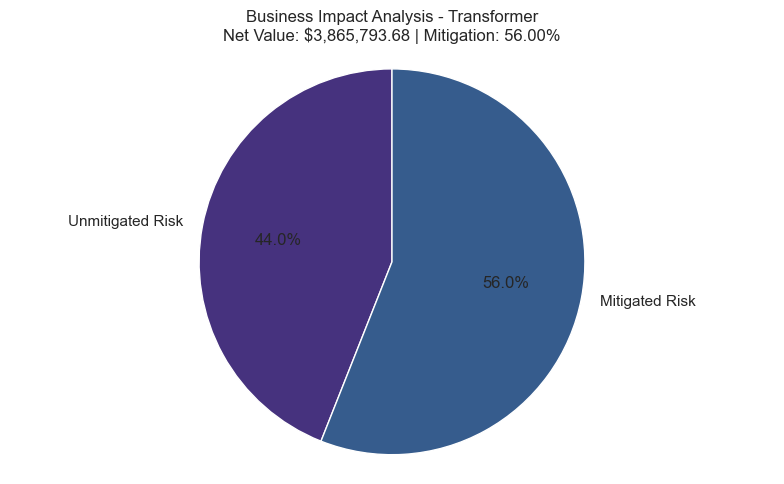

INFO: transformer: total=$8785894.74, mitigated=$4920101.05, net=$3865793.68, pct=56.00%
INFO: Calculating business impact for motor...


<Figure size 640x480 with 0 Axes>

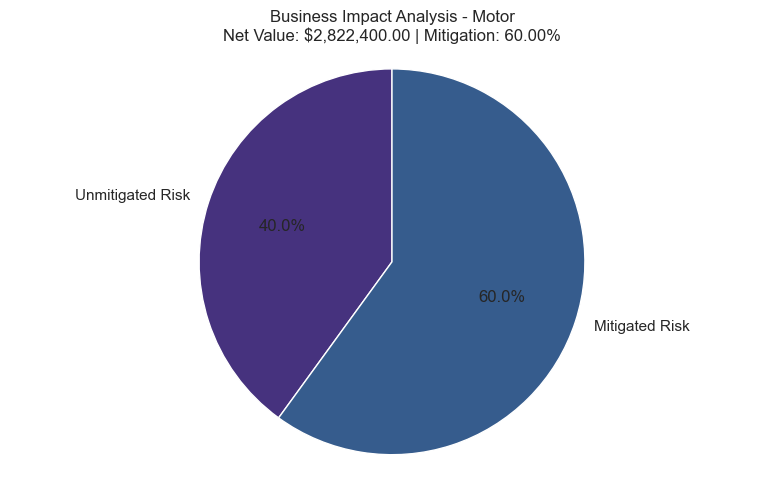

INFO: motor: total=$7056000.00, mitigated=$4233600.00, net=$2822400.00, pct=60.00%
INFO: Calculating business impact for capacitor...


<Figure size 640x480 with 0 Axes>

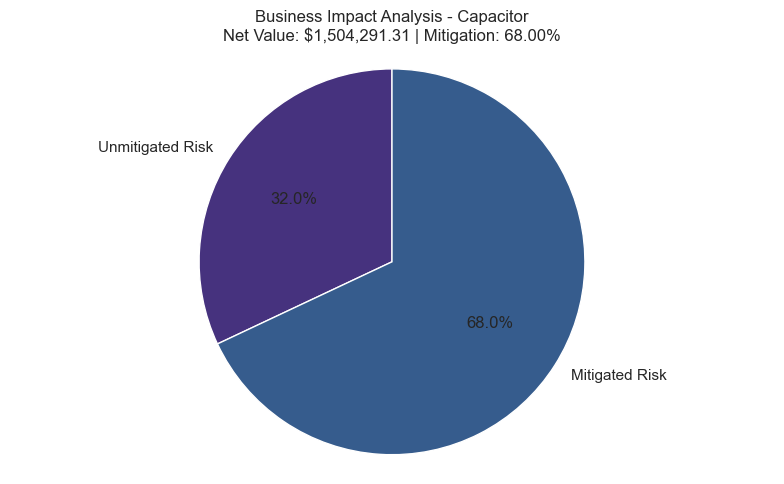

INFO: capacitor: total=$4700910.34, mitigated=$3196619.03, net=$1504291.31, pct=68.00%
INFO: Calculating business impact for ups...


<Figure size 640x480 with 0 Axes>

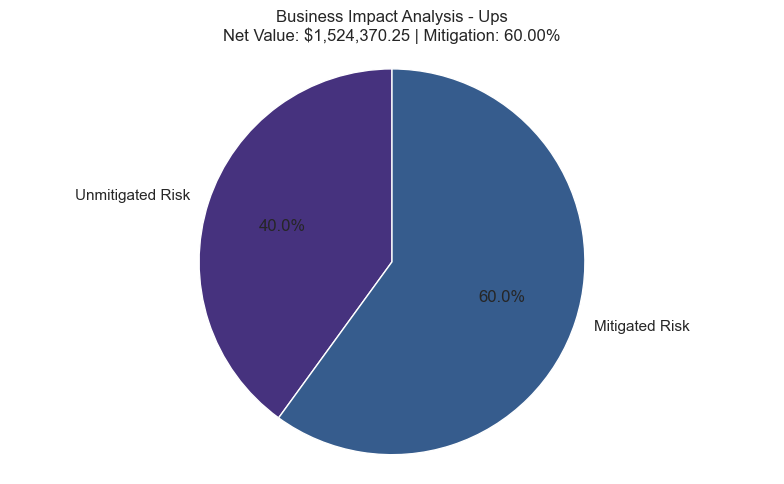

INFO: ups: total=$3810925.63, mitigated=$2286555.38, net=$1524370.25, pct=60.00%


<Figure size 640x480 with 0 Axes>

In [69]:
# 4. Business Impact Analysis (correct calculations WITH plots showing net value)
logging.info("Calculating business impact...")

def calculate_business_impact(asset_type, risk_data, recommendations, df=None):
    PRODUCTION_IMPACT = {'transformer':15000,'motor':12000,'capacitor':8000,'ups':10000}
    total_risk = 0.0
    mitigation_value = 0.0
    
    for asset_id, recs in recommendations.items():
        if asset_id >= len(risk_data['failure_probs']):
            continue
            
        failure_prob = float(risk_data['failure_probs'][asset_id])
        risk = failure_prob * PRODUCTION_IMPACT[asset_type] * 24 * 7
        total_risk += risk
        
        if recs:
            top_rec = recs[0]
            # CORRECTED calculation (proportional to actual risk)
            risk_reduction = failure_prob * (PRODUCTION_IMPACT[asset_type] - top_rec['production_impact']) * 24 * 7
            mitigation_value += risk_reduction * 0.8

    unmitigated = max(total_risk - mitigation_value, 0.0)
    mitigated = min(mitigation_value, total_risk)
    net_value = total_risk - mitigation_value
    
    # Calculate percentage with safety checks
    risk_mitigated_pct = 0.0
    if total_risk > 0:
        risk_mitigated_pct = (mitigation_value / total_risk) * 100

    # Plot (fixed to show in Jupyter AND display net value)
    plt.figure(figsize=(8,5))
    
    if total_risk == 0:
        plt.pie([1], labels=['No Risk'], colors=['#dddddd'])
        plt.title(f'Business Impact Analysis - {asset_type.capitalize()} (No Risk)')
    elif mitigated/total_risk < 0.01:  # Less than 1% mitigation
        # Special handling for very small mitigation
        labels = ['Unmitigated Risk', 'Mitigated Risk']
        values = [total_risk, total_risk * 0.01]  # Show 1% as minimum visible
        colors = ['#ff9999', '#66b3ff']
        plt.pie(values, labels=labels, colors=colors, 
                autopct=lambda p: '{:.2f}%'.format(p) if p > 1 else '', 
                startangle=90)
        plt.title(f'Business Impact Analysis - {asset_type.capitalize()}\n'
                  f'Mitigation: {risk_mitigated_pct:.4f}% | Net Value: ${net_value:,.2f}')
    else:
        # Normal case with net value in title
        values = [unmitigated, mitigated]
        labels = ['Unmitigated Risk', 'Mitigated Risk']
        plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
        plt.title(f'Business Impact Analysis - {asset_type.capitalize()}\n'
                  f'Net Value: ${net_value:,.2f} | Mitigation: {risk_mitigated_pct:.2f}%')
    
    plt.axis('equal')
    plt.tight_layout()
    
    # CRITICAL FIX: Show first, then save, then don't close
    plt.show()  # This ensures plots display in Jupyter
    plt.savefig(RESULTS_DIR / f'business_impact_{asset_type}.png', dpi=200, bbox_inches='tight')
    # REMOVED plt.close() - This was preventing display in Jupyter

    return {
        'total_risk': float(total_risk),
        'mitigation_value': float(mitigation_value),
        'net_value': float(net_value),
        'risk_mitigated_pct': float(risk_mitigated_pct)
    }

business_impact = {}
for asset_type in ['transformer','motor','capacitor','ups']:
    logging.info(f"Calculating business impact for {asset_type}...")
    impact = calculate_business_impact(asset_type, failure_risk[asset_type], 
                                     all_recommendations.get(asset_type, {}), 
                                     datasets[asset_type]['df'])
    business_impact[asset_type] = impact
    logging.info(f"{asset_type}: total=${impact['total_risk']:.2f}, "
                 f"mitigated=${impact['mitigation_value']:.2f}, "
                 f"net=${impact['net_value']:.2f}, "
                 f"pct={impact['risk_mitigated_pct']:.2f}%")

INFO: Creating integrated prescriptive dashboard...


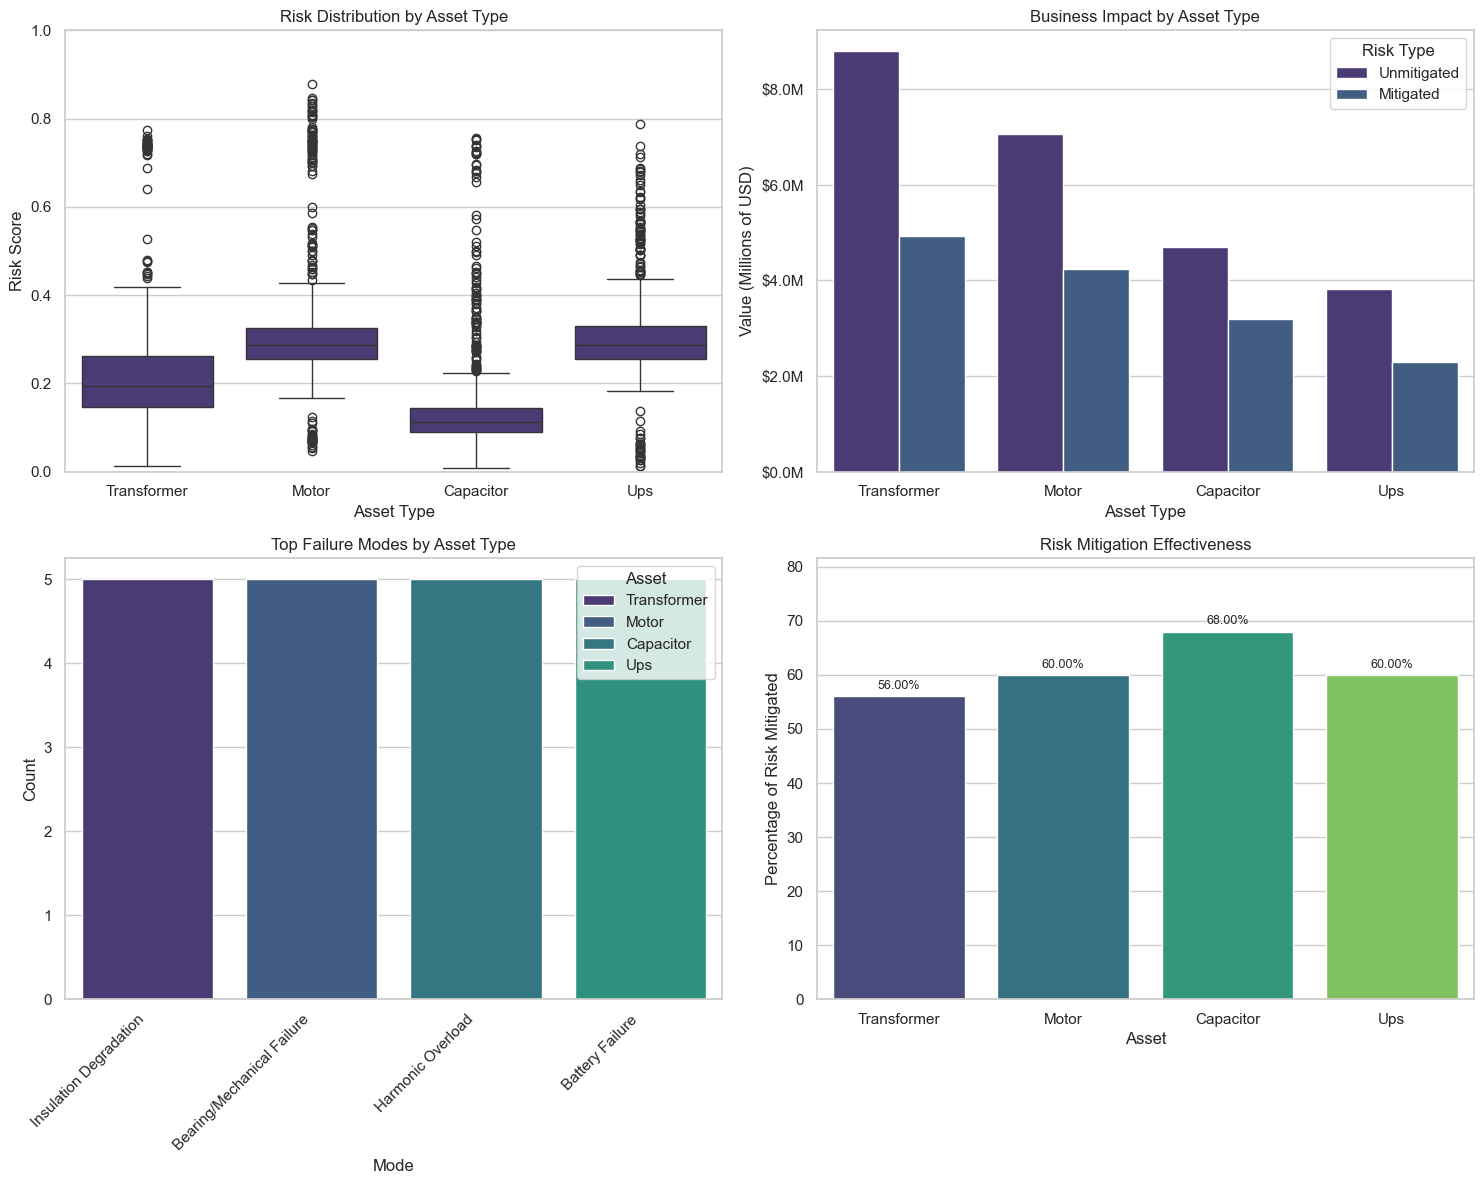

In [68]:
# 5. Integrated Prescriptive Dashboard (with proper axis labels)
logging.info("Creating integrated prescriptive dashboard...")

# Prepare data safely
risk_concat = []
asset_label = []
for asset in ['transformer','motor','capacitor','ups']:
    cr = failure_risk[asset]['combined_risk']
    if cr.size > 0:
        risk_concat.extend(cr.tolist())
        asset_label.extend([asset.capitalize()]*len(cr))

if risk_concat:
    plt.figure(figsize=(15,12))

    # Risk Distribution
    plt.subplot(2,2,1)
    sns.boxplot(x=asset_label, y=risk_concat)
    plt.title('Risk Distribution by Asset Type')
    plt.xlabel('Asset Type')
    plt.ylabel('Risk Score')
    plt.ylim(0,1)

    # Business Impact
    plt.subplot(2,2,2)
    rows = []
    for asset in ['transformer','motor','capacitor','ups']:
        imp = business_impact.get(asset, {'total_risk':0,'mitigation_value':0})
        # Convert to millions for display
        rows.append([asset.capitalize(),'Unmitigated',imp['total_risk']/1e6])
        rows.append([asset.capitalize(),'Mitigated',imp['mitigation_value']/1e6])
    imp_df = pd.DataFrame(rows, columns=['Asset Type','Risk Type','Value (Millions)'])
    
    # Create bar plot with millions
    ax = sns.barplot(x='Asset Type', y='Value (Millions)', hue='Risk Type', data=imp_df)
    
    # Format y-axis as millions
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:.1f}M'))
    
    plt.title('Business Impact by Asset Type')
    plt.ylabel('Value (Millions of USD)')

    # Failure Modes
    plt.subplot(2,2,3)
    mode_rows = []
    for asset, modes in failure_modes.items():
        for _, mi in modes.items():
            mode_rows.append({'Asset':asset.capitalize(),'Mode':mi['failure_mode']})
    if mode_rows:
        mode_df = pd.DataFrame(mode_rows)
        sns.countplot(x='Mode', hue='Asset', data=mode_df)
        plt.xticks(rotation=45, ha='right')
        plt.title('Top Failure Modes by Asset Type')
        plt.ylabel('Count')  # FIXED: Changed from 'count' to 'Count'

    # Risk Mitigation Effectiveness
    plt.subplot(2,2,4)
    eff_rows = []
    for asset in ['transformer','motor','capacitor','ups']:
        eff_rows.append({
            'Asset': asset.capitalize(),
            'Risk Mitigated (%)': business_impact.get(asset, {}).get('risk_mitigated_pct', 0.0)
        })
    eff_df = pd.DataFrame(eff_rows)
    
    # Create bar plot
    ax = sns.barplot(x='Asset', y='Risk Mitigated (%)', data=eff_df, palette='viridis')
    
    # Dynamic y-axis scaling
    max_pct = max(eff_df['Risk Mitigated (%)'])
    if max_pct > 0:
        upper_limit = max(max_pct * 1.2, 5.0)
        plt.ylim(0, upper_limit)
        
        # Add data labels
        for i, p in enumerate(ax.patches):
            pct = eff_df.iloc[i]['Risk Mitigated (%)']
            if pct > 0.1:
                ax.annotate(f'{pct:.2f}%', 
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='bottom',
                           xytext=(0, 3), textcoords='offset points',
                           fontsize=9)
    
    plt.title('Risk Mitigation Effectiveness')
    plt.ylabel('Percentage of Risk Mitigated')

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'prescriptive_dashboard.png', dpi=200, bbox_inches='tight')
    plt.show()

else:
    logging.info("No risk data available to plot dashboard.")

In [67]:
# 6. Sample Prescriptive Report for a Critical Asset
logging.info("Generating sample prescriptive report for a critical asset (if any)...")

critical_asset = None
for asset_type in ['transformer','motor','capacitor','ups']:
    df = datasets[asset_type]['df']
    if 'health_status' in df.columns:
        crit_idx = df.index[df['health_status']=='Critical'].tolist()
        if crit_idx:
            critical_asset = (asset_type, crit_idx[0])
            break

if critical_asset:
    asset_type, asset_id = critical_asset
    logging.info(f"Found critical asset: {asset_type} #{asset_id}")
    d = datasets[asset_type]
    rd = failure_risk[asset_type]
    modes = failure_modes.get(asset_type, {})
    mode_info = modes.get(asset_id, {'failure_mode':'Unknown','confidence':0.0})
    recs = generate_prescriptive_recommendations(asset_type, asset_id, rd, d['df'], mode_info, d['mapping'])

    # Build report (markdown-ish)
    report_lines = [
        "# Prescriptive Maintenance Report",
        f"**Asset Type**: {asset_type.capitalize()}",
        f"**Asset ID**: {asset_id}",
        f"**Current Health Status**: {d['df'].iloc[asset_id].get('health_status','Unknown')}",
        f"**Failure Mode**: {mode_info.get('failure_mode','Unknown')} (Confidence: {mode_info.get('confidence',0.0):.2f})",
        "",
        "## Risk Assessment"
    ]
    if len(rd['failure_probs'])>asset_id:
        report_lines.append(f"- Failure Probability: {rd['failure_probs'][asset_id]:.2%}")
        report_lines.append(f"- Estimated Time to Failure: {rd['time_to_failure'][asset_id]:.1f} days")
        report_lines.append(f"- Risk Score: {rd['combined_risk'][asset_id]:.4f}")
    else:
        report_lines.append("- Failure Probability: N/A")

    report_lines.append("")
    report_lines.append("## Recommended Actions")
    for i,r in enumerate(recs,1):
        report_lines.append(f"{i}. {r['action']} (Urgency: {r['urgency']}, Cost: ${r['cost']:,}, Confidence: {r['confidence']:.2f})")

    # Business impact per-asset fallback (avoid division by zero)
    try:
        n_recs = max(1, len(all_recommendations.get(asset_type, {})))
        bi = business_impact.get(asset_type, {'total_risk':0,'mitigation_value':0,'net_value':0})
        report_lines.append("")
        report_lines.append("## Business Impact")
        report_lines.append(f"- Potential Loss if Unaddressed: ${bi['total_risk']/n_recs:,.2f}")
        report_lines.append(f"- Value of Recommended Actions: ${bi['mitigation_value']/n_recs:,.2f}")
        report_lines.append(f"- Net Value: ${bi['net_value']/n_recs:,.2f}")
    except Exception:
        pass

    report_lines.append(f"\n*Report generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}*")

    report_text = "\n".join(report_lines)
    rpt_path = RESULTS_DIR / f'prescriptive_report_{asset_type}_{asset_id}.md'
    with open(rpt_path, 'w') as f:
        f.write(report_text)
    logging.info(f"Saved sample report: {rpt_path}")
    print(report_text[:1200])
else:
    logging.info("No critical assets found - skipping sample report generation.")

logging.info("Prescriptive engine demo completed. Check the results directory for outputs.")

INFO: Generating sample prescriptive report for a critical asset (if any)...
INFO: Found critical asset: transformer #514
INFO: Saved sample report: ..\results\prescriptive_report_transformer_514.md
INFO: Prescriptive engine demo completed. Check the results directory for outputs.


# Prescriptive Maintenance Report
**Asset Type**: Transformer
**Asset ID**: 514
**Current Health Status**: Critical
**Failure Mode**: Unknown (Confidence: 0.00)

## Risk Assessment
- Failure Probability: 51.69%
- Estimated Time to Failure: 2.0 days
- Risk Score: 0.6415

## Recommended Actions
1. Clean cooling system and check oil flow (Urgency: Immediate, Cost: $850, Confidence: 0.80)

## Business Impact
- Potential Loss if Unaddressed: $1,757,178.95
- Value of Recommended Actions: $984,020.21
- Net Value: $773,158.74

*Report generated on 2025-08-18 20:41:55*
